In [17]:

import numpy as np
from astropy.io import fits, ascii
from astropy.table import Table
import pandas as pd
import matplotlib.pyplot as plt
import glob
import splat
from popsims.relations import polynomial_relation
from splat.photometry import filterMag
import splat.empirical as spe
from tqdm import tqdm
import popsims
from popsims.plot_style import  plot_style
from astropy.coordinates import SkyCoord, Galactic
import astropy.units as u
plot_style()
%matplotlib inline


In [344]:
AREA=18_000*u.degree**2

#filenames
FILENAMES={'Rubin Wide': 'rubin_wide',  'Rubin 10 year': 'rubin_10year'}

#add additional selection
SURVEY_DEPTHS= {
       'Rubin Wide': {'LSST_G': 25., 'LSST_R': 24.7, 'LSST_I': 24.0, 'LSST_Z': 23.3, 'LSST_Y': 22.1}, 
       'Rubin 10 year': {'LSST_G': 25.3, 'LSST_R': 25.6, 'LSST_I': 25.4, 'LSST_Z': 24.9, 'LSST_Y': 24.}, 
}

selection0='LSST_G < 25.0 and LSST_R < 24.7 and LSST_I< 24.0 and LSST_Z < 23.3 and LSST_Y < 22.1'



In [345]:
def compute_vols_and_numbers(data, population, selection=None):
    
    counts={}
    pointings=list(data['volume'][population][0].keys())
    drho=(AREA/len(data['footprint'])).to(u.radian**2)
    sptgrid=data['sptgrid']
    
    for idx, spt in enumerate(sptgrid):
        scale=[df.scale.mean(), df.scale_unc.mean(), df.scale_times_model.mean()]
        sn= len(df)
        
        select='spt < {}'.format(spt, spt+0.9)
        if selection !=None:
            select= select+'and '+selection
            
        sn_c= len(df.query(select))
        
        val=sn_c*np.divide(scale[-1], sn) #fraction compared to local LF
        
        #compute selection correction by pointing
        n=0.0
        for p in pointings:
            v=data['volume'][population][idx][p]*val*drho
            n += v.value
        cnts={'number': n}
        counts.update({spt: cnts})
    fn=pd.DataFrame.from_records(counts).T
    fn['spt']=sptgrid
    return fn


In [346]:
ns=compute_vols_and_numbers(data, 'thin_disk', selection=selection0)

[None]

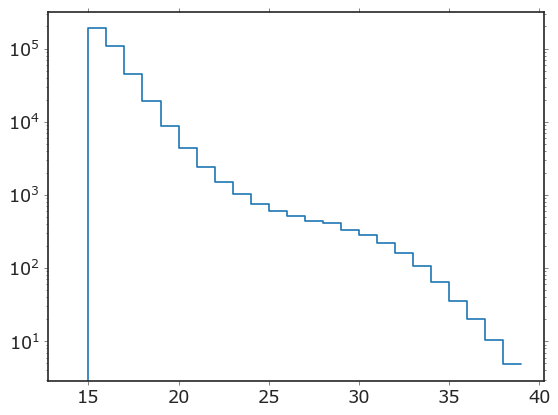

In [347]:
fig, ax=plt.subplots()
plt.step(ns.spt, ns.number)
ax.set(yscale='log')

In [333]:
ns.number.sum()/1e6

4.272189116803273

In [145]:
#CONTROL FOR DIFFERENCE IN AREA
ns=get_numbers('JWST PASSAGE')

In [146]:
ns1=get_numbers('JWST JADES')

[None]

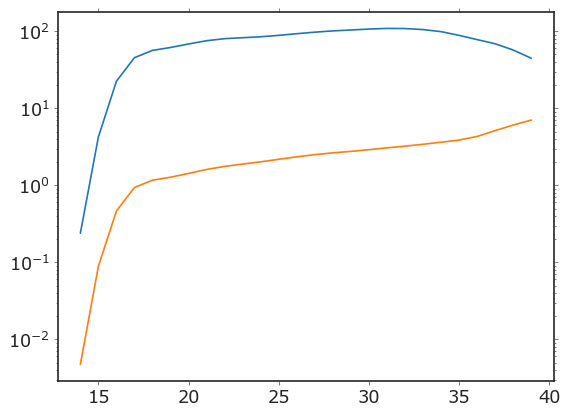

In [149]:
fig, ax=plt.subplots()
plt.plot(sptgrid, ns[0]['thin_disk']/f)
plt.plot(sptgrid, ns1[0]['thin_disk'])

ax.set(yscale='log')


In [144]:
f

<Quantity 7.63076923>

In [6]:
#area

In [22]:
data['volume']['thin_disk']

[665669647321.5032,
 208001423459.01846,
 79774656580.99745,
 31682247695.183926,
 13033045688.330265,
 5604417710.315717,
 2575057145.133899,
 1294629165.1007524,
 723253656.986485,
 450731673.1224464,
 311314171.5791987,
 234851322.8718005,
 189621899.35878643,
 160003248.07086208,
 137536084.05999854,
 117385022.82598864,
 97085242.68466216,
 81516750.14116159,
 64741778.484225646,
 47311727.90717848,
 31410272.140340924,
 18809837.22311132,
 10158553.586608298,
 4988972.586959551,
 2268894.797992233,
 983939.1074966484]

[None]

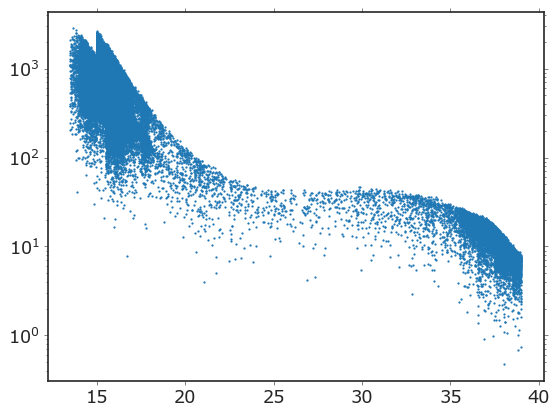

In [8]:
fig, ax=plt.subplots()
ax.scatter(df.spt, df.distance, s=1)
ax.set(yscale='log')

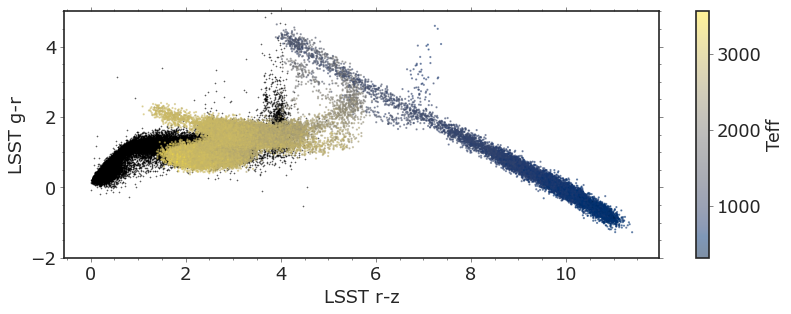

In [11]:
fig, ax=plt.subplots(figsize=(12, 4))
ax.scatter( dp0_data.mag_r-dp0_data.mag_z, dp0_data.mag_g-dp0_data.mag_r, color='k', label='DP0 Data', s=.1)
c=ax.scatter( df.LSST_R-df.LSST_Z, df.LSST_G-df.LSST_R,c=df.temperature, cmap='cividis', s=1, alpha=0.5)
plt.colorbar(c, label='Teff')
ax.set(ylabel='LSST g-r', xlabel='LSST r-z', ylim=[-2, 5])
ax.minorticks_on()

plt.savefig('../figures/lsst_color_selections.jpeg', bbox_inches='tight')


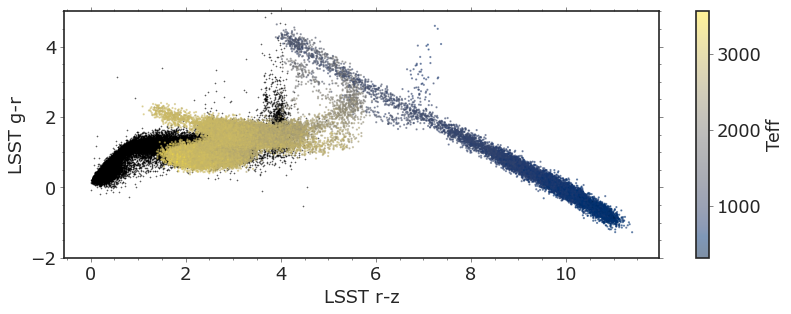

In [ ]:
#other color and